In [34]:
import os
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from upsetplot import UpSet, from_indicators, from_memberships

os.chdir('/lustre/home/reynaj/Projects/20241011.Byrd_Lab.IBD_NuLisa')

da_levels = ['N/A (Non-IBD Control)', 'Quiescent', 'Mild', 'Moderate']

## Load the DEG results for disease activity

In [35]:
qu_df = pd.read_table('results/limma/limma.all_data.disease_activity.control_versus_quiescent.tsv')
qu_df.loc[:, 'group'] = 'quiescent'
top_qu_df = qu_df.loc[(qu_df['P.Value'] < 0.05), :]

In [36]:
mild_df = pd.read_table('results/limma/limma.all_data.disease_activity.control_versus_mild.tsv')
mild_df.loc[:, 'group'] = 'mild'
top_mild_df = mild_df.loc[(mild_df['P.Value'] < 0.05), :]

In [37]:
mod_df = pd.read_table('results/limma/limma.all_data.disease_activity.control_versus_moderate.tsv')
mod_df.loc[:, 'group'] = 'moderate'
top_mod_df = mod_df.loc[(mod_df['P.Value'] < 0.05), :]

## Load the importance scores from the RF model for disease activity

In [38]:
model_imp_df = pd.read_table('results/rf_model/rf_model.disease_activity.scores.tsv', index_col=0)
model_imp_df.loc[:, 'group'] = 'rf_model'

In [39]:
topn = 30
top_model_imp_df = model_imp_df.sort_values('score', ascending=False).head(topn) 

## Compare the overlaps between all groups (Upset Plot)

In [40]:
combined_df = pd.concat([top_qu_df, top_mild_df, top_mod_df, top_model_imp_df])

In [41]:
combined_df.head()

,logFC,AveExpr,t,P.Value,adj.P.Val,B,group,score
CCL26,6.977963,6.553678,3.220985,0.001814,0.265474,-1.342131,quiescent,NaN
CD80,3.324990,7.790100,3.169867,0.002124,0.265474,-1.468340,quiescent,NaN
OSMR,-1.088220,13.950855,-2.641040,0.009842,0.402320,-2.680455,quiescent,NaN
IL2RA,5.722596,5.667477,2.611616,0.010660,0.402320,-2.742639,quiescent,NaN
PDCD1LG2,3.765880,3.510628,2.596863,0.011093,0.402320,-2.773601,quiescent,NaN


In [42]:
# generate the data for the upset plot
upset_df = combined_df.reset_index()
upset_df.rename(columns={'index': 'protein'}, inplace=True)
upset_df.loc[:, 'indicator'] = 1
upset_df = upset_df.loc[:, ['protein', 'group', 'indicator']]
upset_df = upset_df.pivot(index='protein', columns=['group'], values='indicator')
upset_df = upset_df.fillna(0).astype(bool).reset_index()
upset_df = from_indicators(indicators=['quiescent', 'mild', 'moderate', 'rf_model'], data=upset_df)

In [43]:
upset_df.head()

group                             protein   mild  moderate  quiescent  \
quiescent mild  moderate rf_model                                       
False     False False    True        AGER  False     False      False   
                         True       CCL11  False     False      False   
True      True  True     False      CCL26   True      True       True   
False     False False    True        CD27  False     False      False   
          True  False    True       CD276   True     False      False   

group                              rf_model  
quiescent mild  moderate rf_model            
False     False False    True          True  
                         True          True  
True      True  True     False        False  
False     False False    True          True  
          True  False    True          True

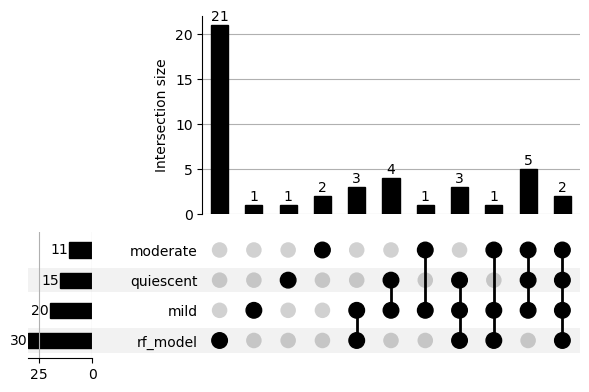

In [44]:
# Create UpSet plot
upset = UpSet(upset_df, show_counts=True)
upset.plot();

In [45]:
upset_df.loc[(True, True, True, True)]

/tmp/ipykernel_3128466/2097476119.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  upset_df.loc[(True, True, True, True)]


group                            protein  mild  moderate  quiescent  rf_model
quiescent mild moderate rf_model                                             
True      True True     True        CD80  True      True       True      True
                        True       IL36B  True      True       True      True

## Plot gene expression for interesting genes across the RF Model and all other groups

In [46]:
# Load the protein levels data
protein_data = pd.read_csv("results/comp_data/protein_levels.npq.tsv", sep="\t")
protein_data = protein_data.T

# Load the clinical data
clinical_data = pd.read_csv("results/comp_data/clinical_data.tsv", sep="\t")

# remove alamar samples
keep = (~clinical_data['sample_id'].str.contains('SC_Rep')).tolist()
clinical_data = clinical_data.loc[keep,:]
protein_data = protein_data.loc[keep,:]

# combine protein with clinical data
clinical_data.index = clinical_data.sample_id
comp_protein_data = pd.concat([protein_data, clinical_data[['disease_activity']]], axis=1)

In [47]:
comp_protein_data

,AGER,AGRP,ANGPT1,ANGPT2,ANXA1,AREG,BDNF,BMP7,BST2,C1QA,...,TSLP,VCAM1,VEGFA,VEGFC,VEGFD,VSNL1,VSTM1,WNT16,WNT7A,disease_activity
TRP-34082,5.493463,8.765074,15.76212,11.250206,17.79754,14.68076,0.000000,7.512066,10.206268,8.081331,...,10.94101,0.000000,18.23954,16.68403,9.214276,22.58694,14.75831,7.103437,8.497241,Quiescent
TRP-34086,4.453723,10.299592,17.59438,11.835780,16.49940,14.91346,9.248813,9.961362,11.179836,8.589964,...,11.29018,7.094106,18.36369,19.17019,8.799946,20.19290,17.99542,7.941584,8.232622,Quiescent
TRP-42335,6.469100,11.617355,17.49572,12.059989,20.11341,12.85620,0.000000,8.614946,9.096235,9.529024,...,11.47073,0.000000,18.52676,18.22880,7.187657,20.12907,17.56549,5.531130,5.503245,Quiescent
TRP-42324,5.398481,8.084902,18.85520,11.783576,20.28382,13.00942,0.000000,8.196127,10.835604,0.000000,...,11.29977,0.000000,18.23974,17.62960,8.247575,20.06370,17.24266,0.000000,8.372645,Quiescent
TRP-42322,5.444545,9.068033,18.69799,12.531015,19.71289,16.21479,0.000000,9.476020,16.270733,10.781654,...,11.17309,0.000000,18.78044,18.04191,11.034922,21.84698,17.57186,8.126035,9.796662,Quiescent
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TRP-061-48257-1,8.127315,9.255260,16.84491,13.986322,15.68363,14.97625,0.000000,9.085405,12.137737,8.962350,...,11.69308,5.677853,19.59215,19.75581,8.978430,20.72274,15.45789,7.706452,7.113487,N/A (Non-IBD Control)
TRIANGLE PEDS-042-48265-3,7.982089,10.203504,18.07924,13.746561,15.09273,14.10205,0.000000,10.694729,11.716239,7.723660,...,11.91448,8.632788,19.41014,19.12566,9.214830,20.67782,18.93481,8.506379,8.315130,Quiescent
TRP-063-48262-3,6.178675,9.750478,18.14120,12.530637,17.62608,14.59775,0.000000,8.807570,13.462587,9.360695,...,11.38831,0.000000,18.84261,18.33493,7.370969,22.39336,14.68536,7.849187,7.756246,Quiescent
TRP-064-48267-3,0.000000,9.101757,17.82236,13.488132,18.23443,14.26034,0.000000,9.580366,12.357140,9.829992,...,12.74102,0.000000,19.02105,18.21655,9.419982,21.68461,13.52384,5.297514,8.222748,N/A (Non-IBD Control)


### Completely shared protein levels

In [48]:
completely_shared = upset_df.loc[(True, True, True, True), 'protein'].tolist()

/tmp/ipykernel_3128466/1199594084.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  completely_shared = upset_df.loc[(True, True, True, True), 'protein'].tolist()


In [49]:
completely_shared

['CD80', 'IL36B']

In [50]:
def da_boxplot(data, protein):
    fig, ax = plt.subplots()
    sns.boxplot(data=data, x='disease_activity', y=protein, order=da_levels, ax=ax)
    ax.set_title('{} levels across disease activity'.format(protein))
    return(fig, ax)

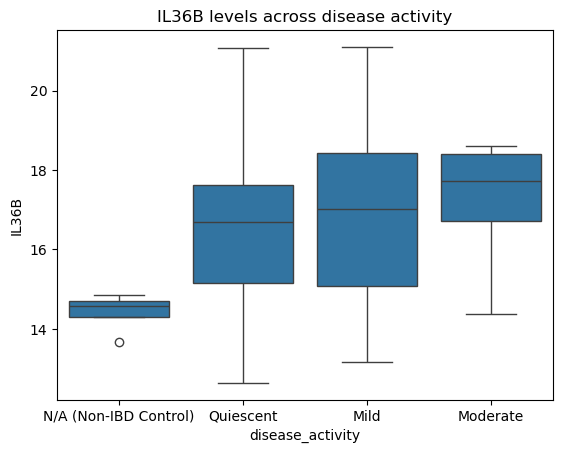

In [51]:
protein = 'IL36B'
fig, ax = da_boxplot(comp_protein_data, protein)

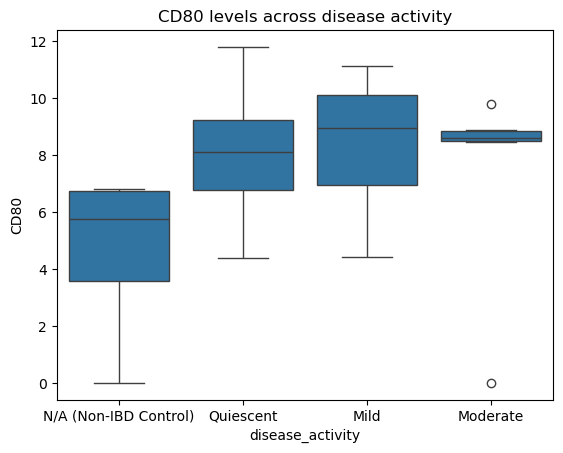

In [52]:
protein = 'CD80'
fig, ax = da_boxplot(comp_protein_data, protein)

### Shared between RF and Mild

/tmp/ipykernel_3128466/833185012.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  shared = upset_df.loc[(False, True, False, True), 'protein'].tolist()


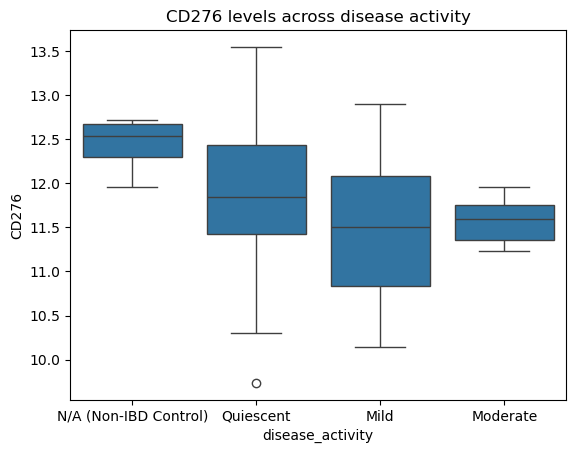

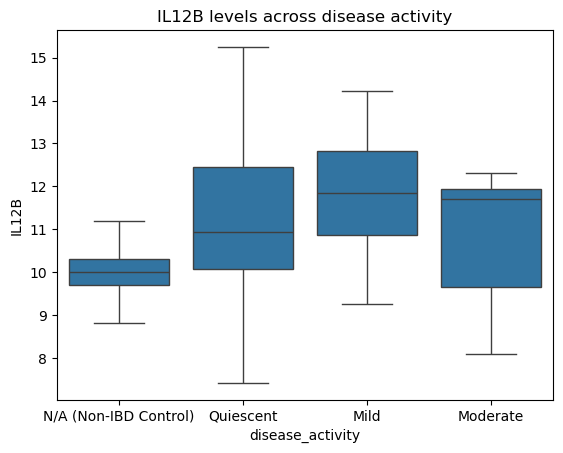

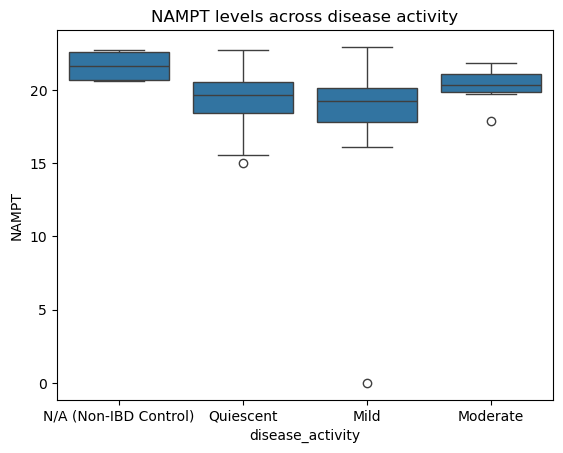

In [53]:
shared = upset_df.loc[(False, True, False, True), 'protein'].tolist()
for protein in shared:
    fig, ax = da_boxplot(comp_protein_data, protein)

### Shared between RF, Quiescent and Mild 

/tmp/ipykernel_3128466/3522891480.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  shared = upset_df.loc[(True, True, False, True), 'protein'].tolist()


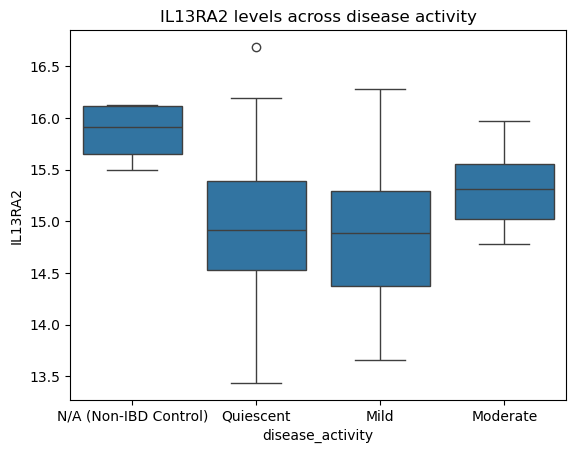

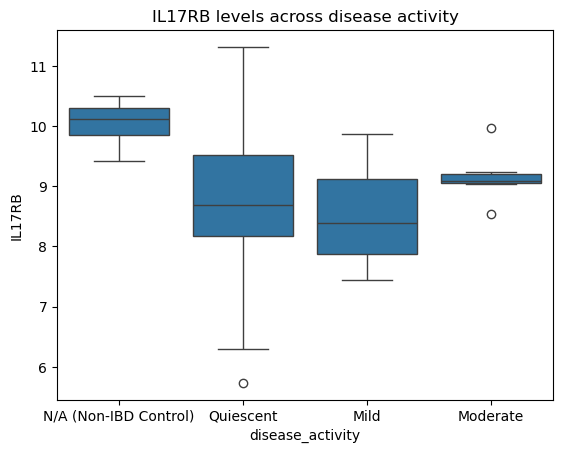

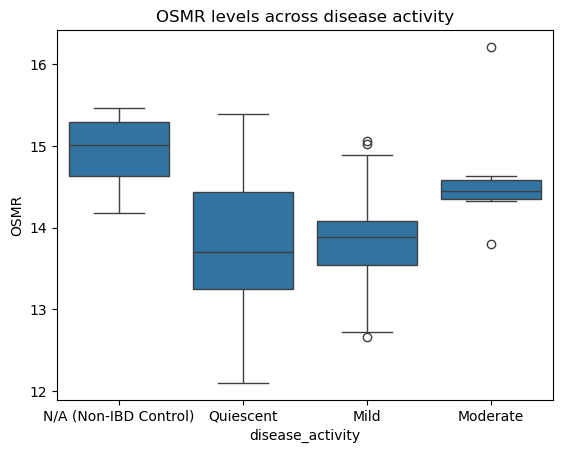

In [54]:
shared = upset_df.loc[(True, True, False, True), 'protein'].tolist()
for protein in shared:
    fig, ax = da_boxplot(comp_protein_data, protein)

### Shared between RF, Mild and Moderate

/tmp/ipykernel_3128466/1527812757.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  shared = upset_df.loc[(False, True, True, True), 'protein'].tolist()


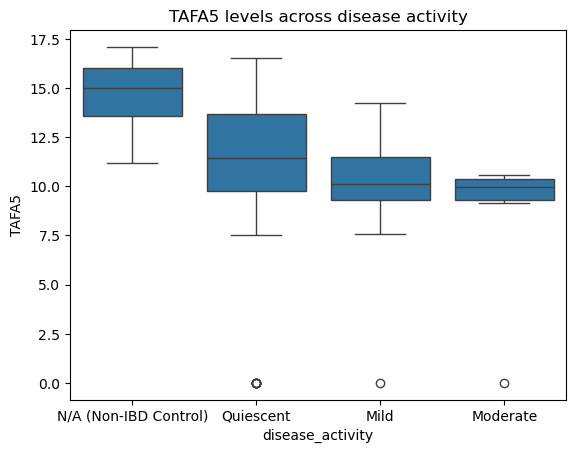

In [55]:
shared = upset_df.loc[(False, True, True, True), 'protein'].tolist()
for protein in shared:
    fig, ax = da_boxplot(comp_protein_data, protein)

## Genes important only in RF 

/tmp/ipykernel_3128466/1436001744.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  shared = upset_df.loc[(False, False, False, True), 'protein'].tolist()
/tmp/ipykernel_3128466/1941974454.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


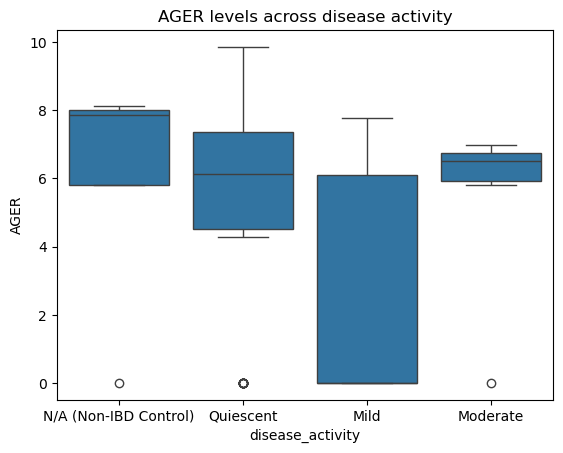

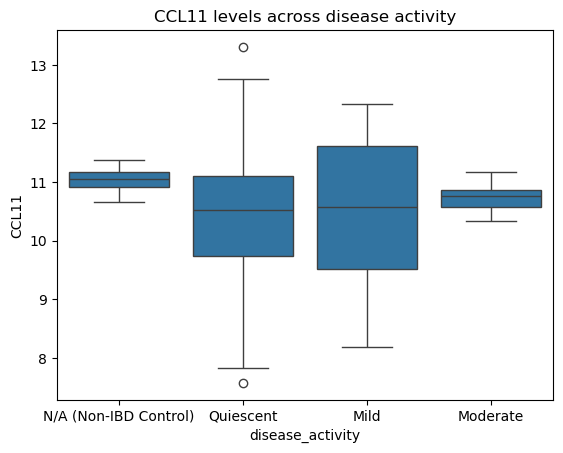

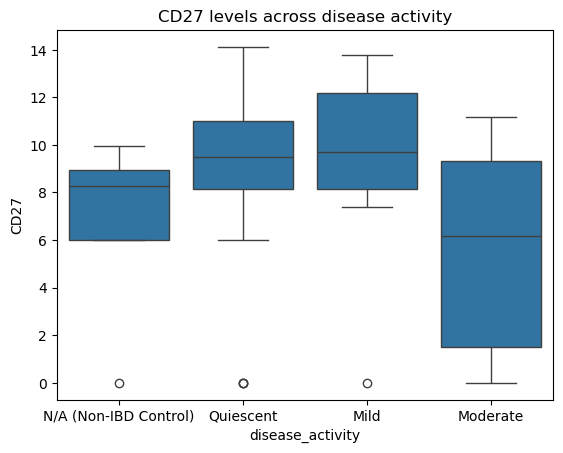

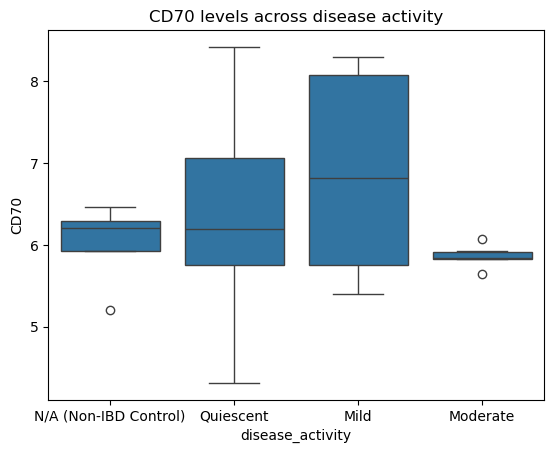

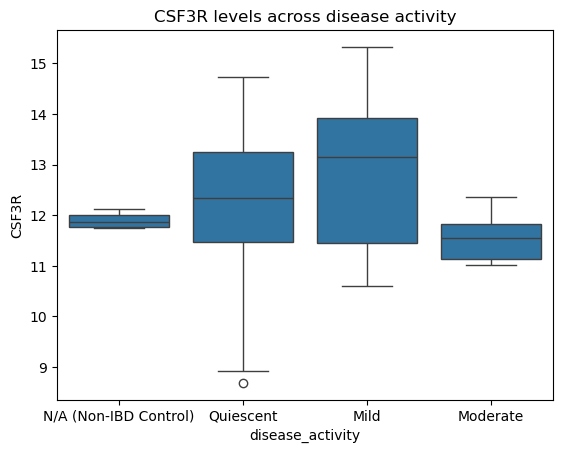

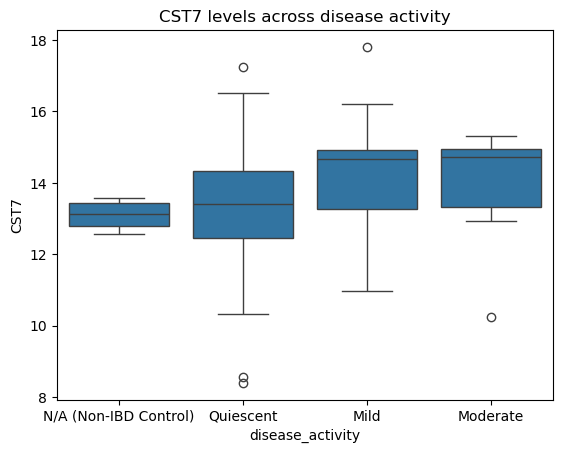

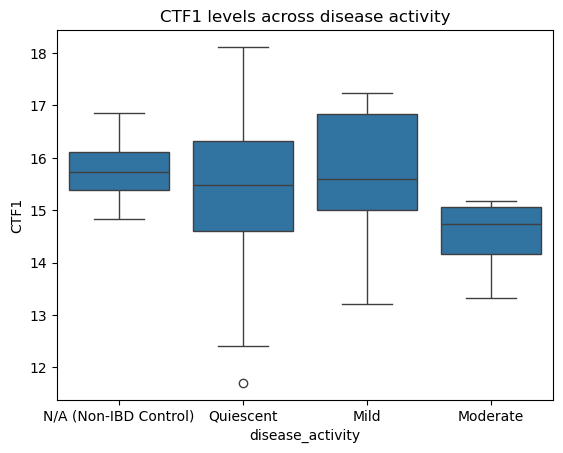

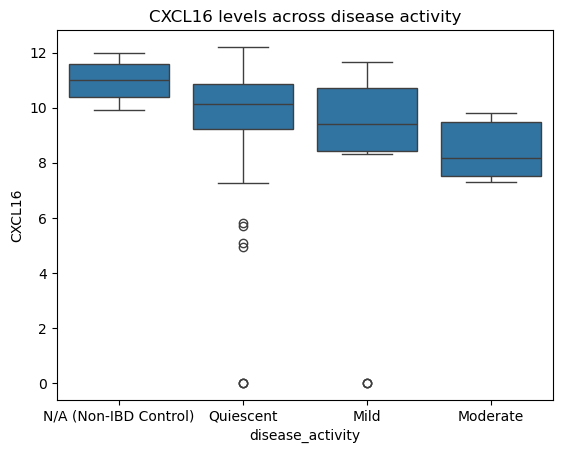

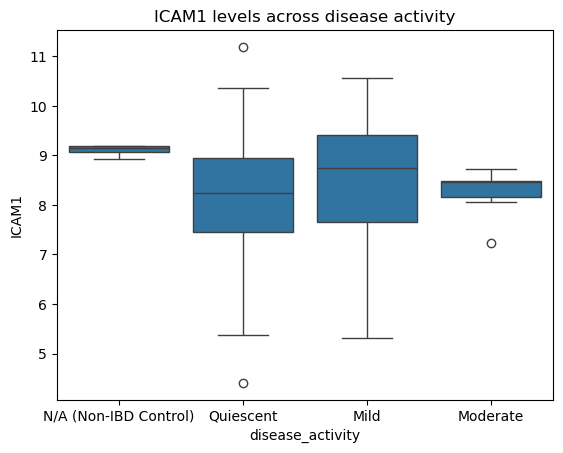

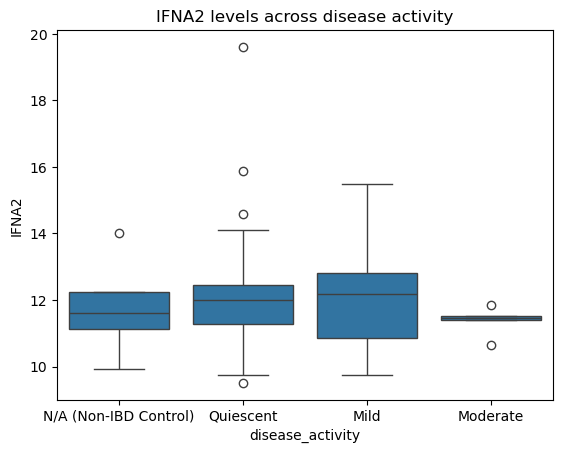

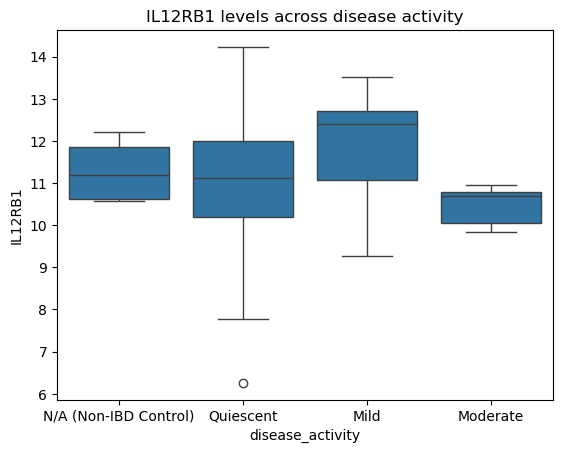

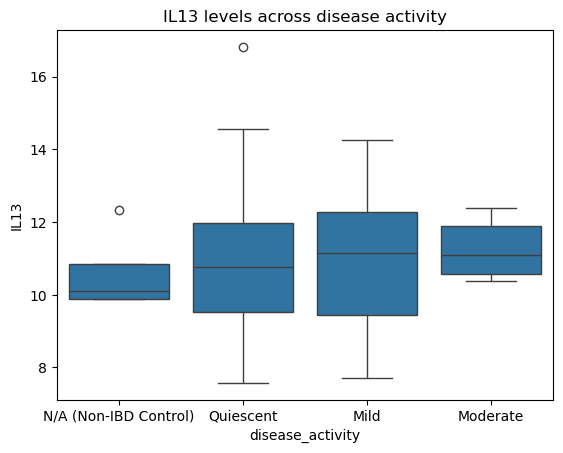

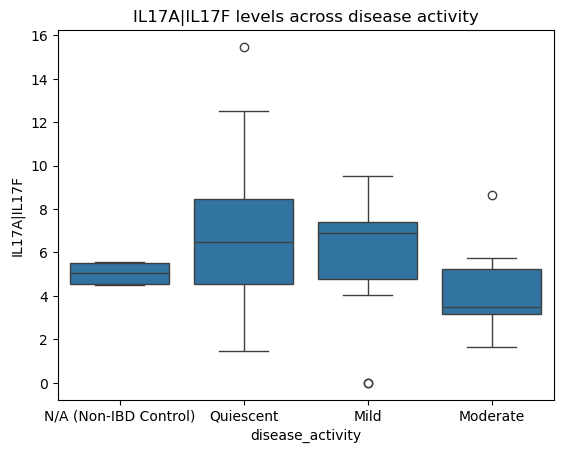

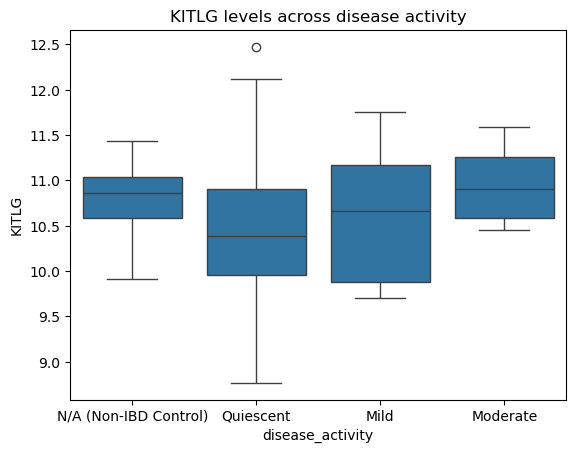

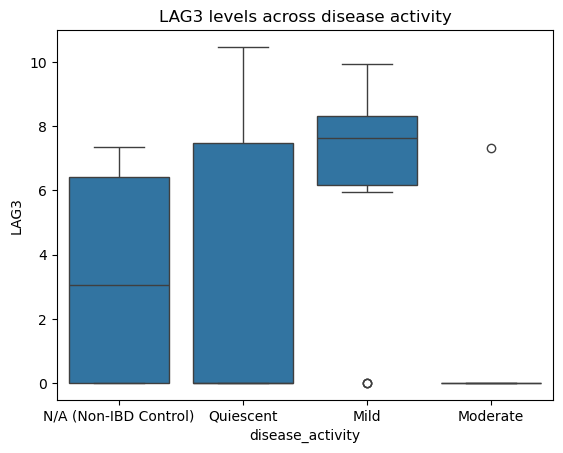

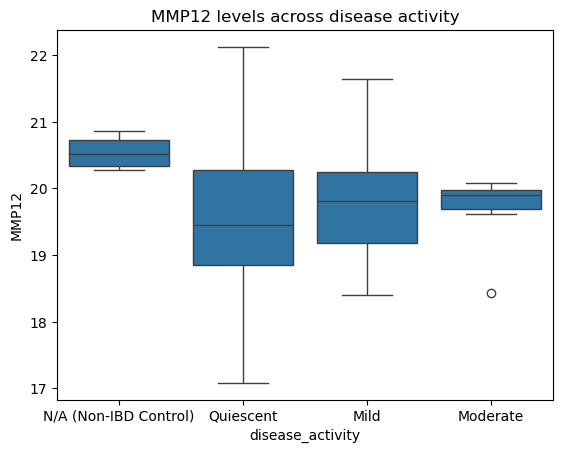

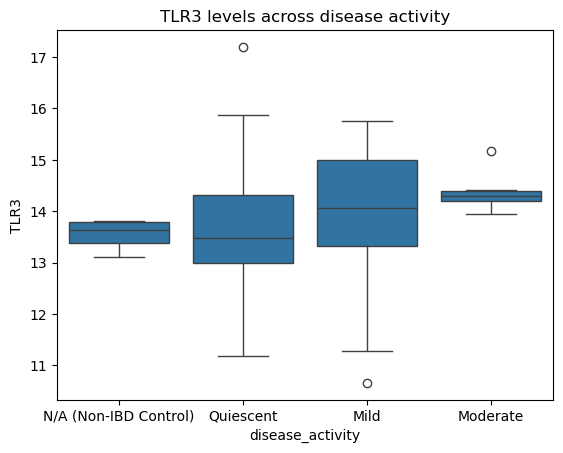

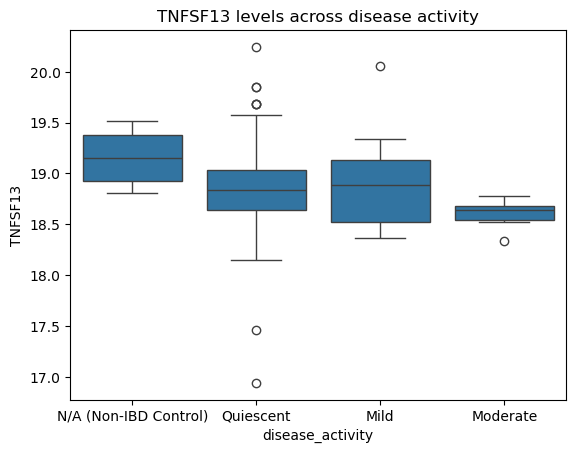

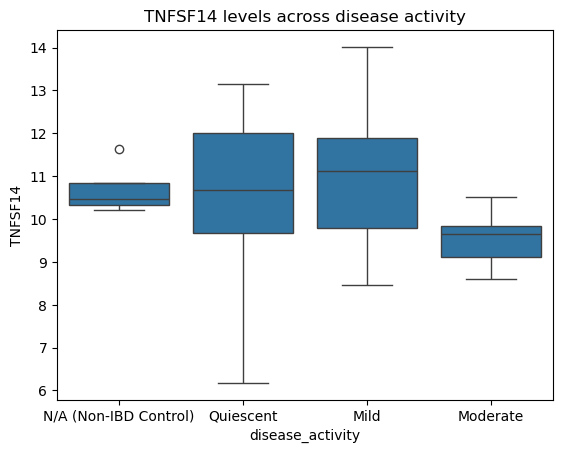

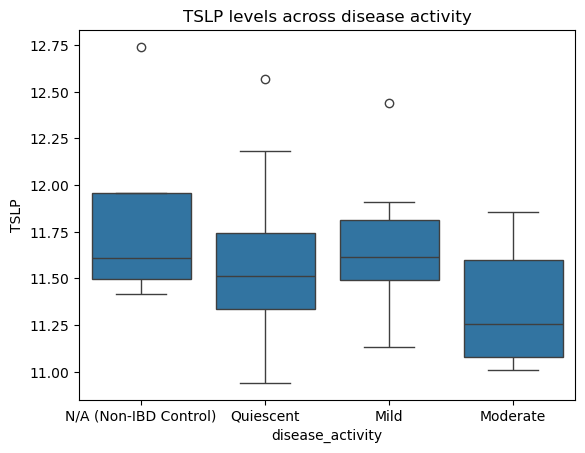

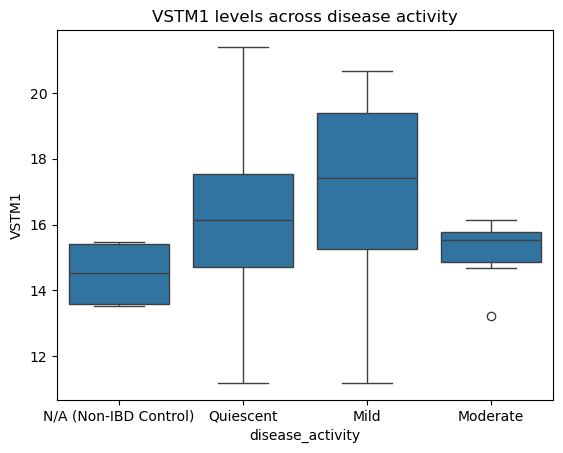

In [56]:
shared = upset_df.loc[(False, False, False, True), 'protein'].tolist()
for protein in shared:
    fig, ax = da_boxplot(comp_protein_data, protein)